# Extract ships from Sentinel-1 data with AIS

Morten Dam Joergensen <mdj@mdj.dk>

This notebook shows how to combine AIS data relying position information from ships, with Synthetic Aperture Radar Imagery from the ESA Sentinel-1 satellites.

In [125]:
import numpy as np
import matplotlib.pylab as plt
import rasterio
import datetime
import hashlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
ais_filename = '/home/mdj/Datasets/ais/aisdk_20181006.csv'
sar_filename= '/home/mdj/S1A_IW_SLC__1SDV_20181006T054021_20181006T054048_024011_029F96_1702_Orb_Cal_deb_ML_Spk_TC.tif'

In [4]:
with rasterio.open(sar_filename) as sar_ds:
    print(sar_ds.width, sar_ds.height)
    print(sar_ds.crs)
    print(sar_ds.transform)
    print(sar_ds.count)
    print(sar_ds.indexes)
    band1 = sar_ds.read(1)

36467 15315
+init=epsg:4326
| 0.00, 0.00, 7.32|
| 0.00,-0.00, 58.44|
| 0.00, 0.00, 1.00|
1
(1,)


In [5]:
def extract_image_at_coord(ds,lon,lat,width,height):
    centoid = ds.index(lon, lat)
    dx, dy = ds.res  
    snip = band1[centoid[0]-int(height//2):centoid[0]+int(height//2), centoid[1]-int(width//2):centoid[1]+int(width//2)]
    return snip

In [151]:
pos = (10.6052186114385, 57.678537912278955)
pos_time = datetime.datetime.strptime("2018-10-06 05:40:31:251 AM", '%Y-%m-%d %I:%M:%S:%f %p')
print(pos_time)
img = extract_image_at_coord(sar_ds, pos[0], pos[1], 256.0, 256.0)


2018-10-06 05:40:31.251000


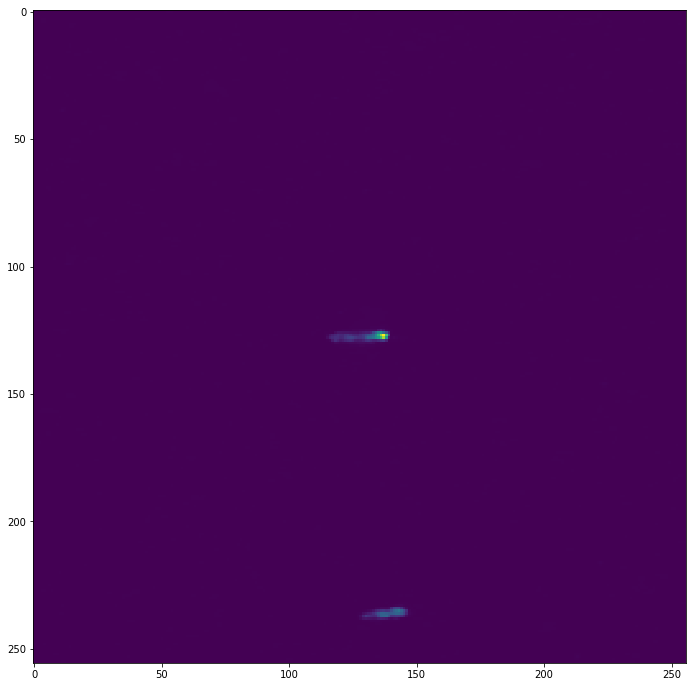

In [152]:
plt.imshow(img)

In [154]:
img_win = (256, 256)

In [155]:
timeWindow = 15.0 # Seconds
imgs = []

sar_time_lw = pos_time - datetime.timedelta(seconds=timeWindow)
sar_time_hw = pos_time + datetime.timedelta(seconds=timeWindow)

hdr = ""
with open(ais_filename,'r') as file:
    for idx, al in enumerate(file):
        if al[0] == "#":
            print(al)
            hdr = al
            continue
        
        al = al.split(',')
        ltime = datetime.datetime.strptime(al[0], '%d/%m/%Y %H:%M:%S')
        mmsi = al[2]
        centroid = (float(al[4]), float(al[3]))
        
        if ltime < sar_time_lw:
            continue 
            
        if ltime > sar_time_hw:
            print(ltime - pos_time)
            break

        if (centroid[0] < sar_ds.bounds.left or centroid[0] > sar_ds.bounds.right) or (centroid[1] < sar_ds.bounds.bottom or centroid[1] > sar_ds.bounds.top):
            # Out of bunds
            continue
            
#         if abs((pos_time - ltime).seconds) < timeWindow:
#         print(al)
#             print(ltime)

        img = extract_image_at_coord(sar_ds, centroid[0], centroid[1], img_win[0], img_win[1])
        imgs.append((img, centroid, ltime, mmsi, al))

# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,IMO,Callsign,Name,Ship type,Cargo type,Width,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D

0:00:15.749000


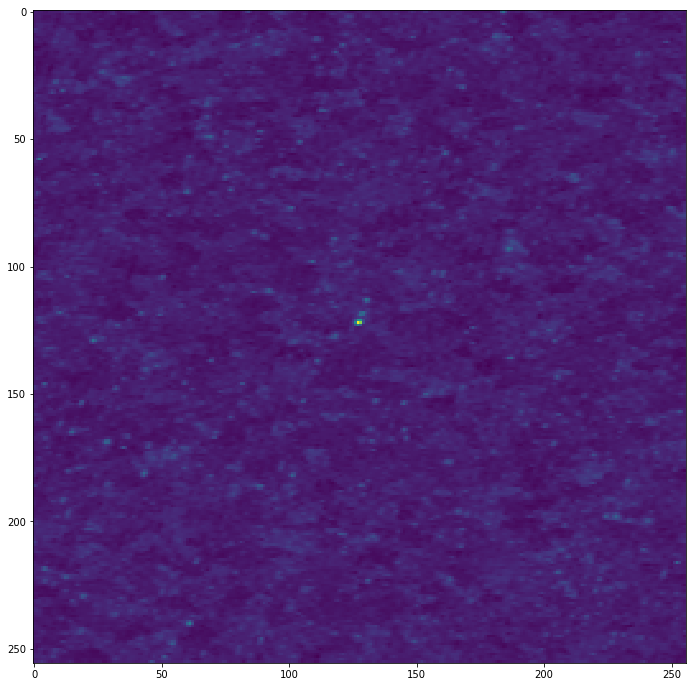

# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,IMO,Callsign,Name,Ship type,Cargo type,Width,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
 ['06/10/2018 05:40:17', 'Class B', '219006593', '57.523017', '9.536535', 'Unknown value', '', '4.3', '334.8', '334', 'Unknown', '', 'HG 124 NIPPON', 'Fishing', '', '4', '12', 'GPS', '', '', '', 'AIS', '9', '3', '1', '3\n']


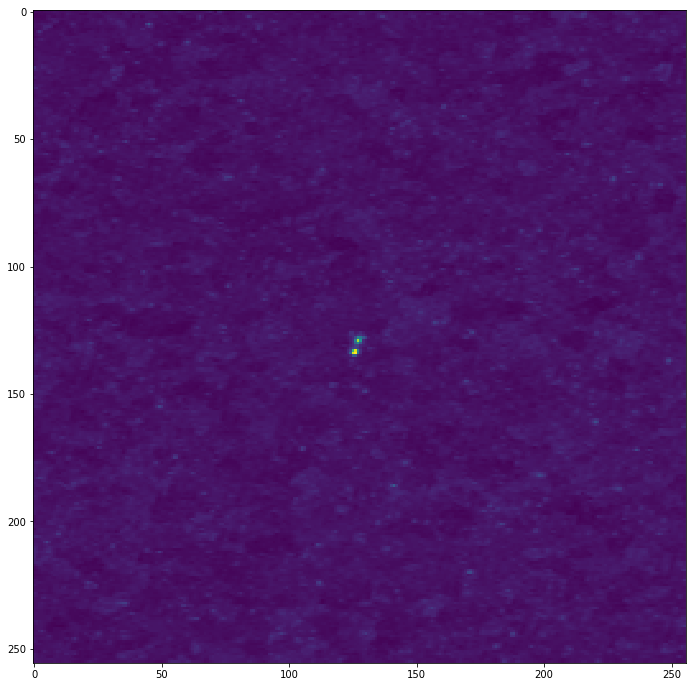

# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,IMO,Callsign,Name,Ship type,Cargo type,Width,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
 ['06/10/2018 05:40:17', 'Class B', '219005836', '57.354997', '8.440968', 'Unknown value', '', '0.8', '122.4', '', 'Unknown', 'XP4475', 'M.S.- NORDSOEN', 'Fishing', '', '4', '12', 'Undefined', '', '', '', 'AIS', '8', '4', '2', '2\n']


In [157]:
for img in imgs[24:26]:
    plt.imshow(img[0])
    plt.show()
    print(hdr, img[4])

## Segmentation mask generation

In [193]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [173]:
from skimage.segmentation import chan_vese
from skimage.filters import threshold_mean, threshold_minimum

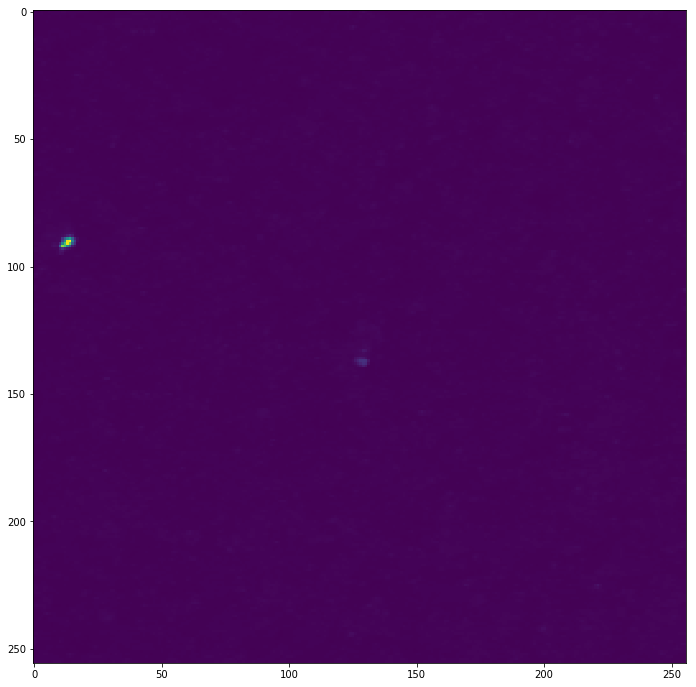

In [174]:
plt.imshow(imgs[2][0])

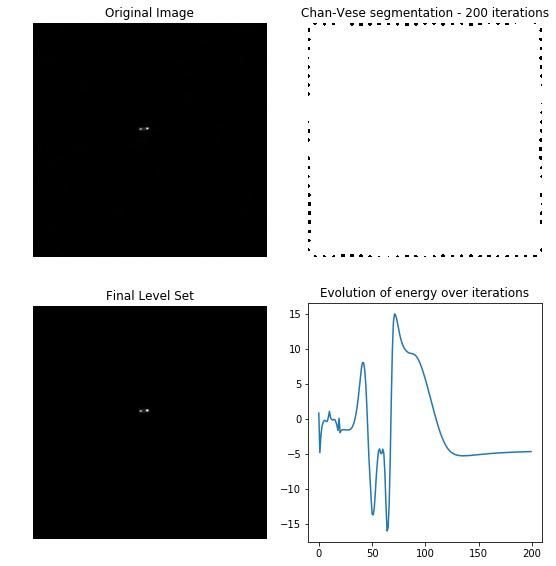

In [175]:
imid = 22
cv = chan_vese(imgs[imid][0], mu=0.08, lambda1=0.01, lambda2=1, tol=1e-4, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

thresh = threshold_minimum(cv[1])
binary = cv[1] > thresh

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(imgs[imid][0], cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

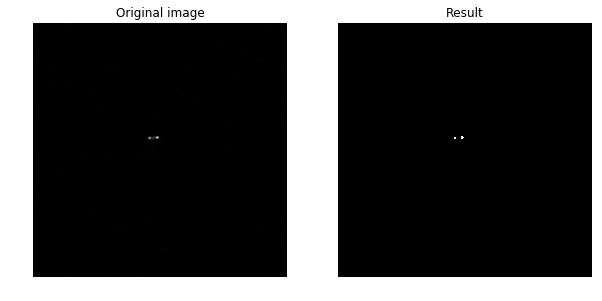

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
ax = axes.ravel()

ax[0].imshow(imgs[imid][0], cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

In [201]:
folder = "/tmp/segtest"
import os
imgs_mask = []
os.makedirs("%s" % (folder),exist_ok=True)
with open(os.path.join(folder, "target_mask.csv"), 'w') as csvf:
    csvf.write("img,rle_mask\n")
    for img in imgs:
        cv = chan_vese(img[0], mu=0.08, lambda1=0.01, lambda2=1, tol=1e-4, max_iter=200,
                   dt=0.5, init_level_set="checkerboard", extended_output=True)

        thresh = threshold_minimum(cv[1])
        mask = cv[1] > thresh
        rle = rle_encode(mask)

        imgs_mask.append(mask)
        name = hashlib.sha256(str(img[4]).encode('utf-8')).hexdigest()
        classname = img[4][13]

        os.makedirs("%s/%s" % (folder, classname),exist_ok=True)
        plt.imsave("%s/%s/%s.png" % (folder, classname,name), img[0])
        plt.imsave("%s/%s/%s_mask.png" % (folder, classname,name), mask)
        csvf.write("%s.png,%s\n" % (name, rle))



In [202]:
str(imgs[1][4])

"['06/10/2018 05:40:17', 'Class A', '248689000', '57.816000', '10.748000', 'Under way using engine', '', '10.3', '293.5', '285', '9507350', '9HA2471', 'WILSON ALGECIRAS', 'Cargo', 'No additional information', '12', '88', 'GPS', '3.3', 'NO. MYRE', '10/10/2018 01:00:00', 'AIS', '74', '14', '7', '5\\n']"

# Clutter tile generation

In [203]:
def extract_image_at_px(ds,x,y,width,height):
    centoid = (x,y)
    dx, dy = ds.res  
    snip = band1[centoid[0]-int(height//2):centoid[0]+int(height//2), centoid[1]-int(width//2):centoid[1]+int(width//2)]
    return snip

In [204]:

clutterimgs = []
for x in range(img_win[0]//2, sar_ds.shape[0], img_win[0]):
    for y in range(img_win[1]//2, sar_ds.shape[1], imgdim[1]):
        clutterimgs.append([extract_image_at_px(sar_ds, x, y, img_win[0], img_win[1]), x,y])

In [205]:
len(clutterimgs)

21840

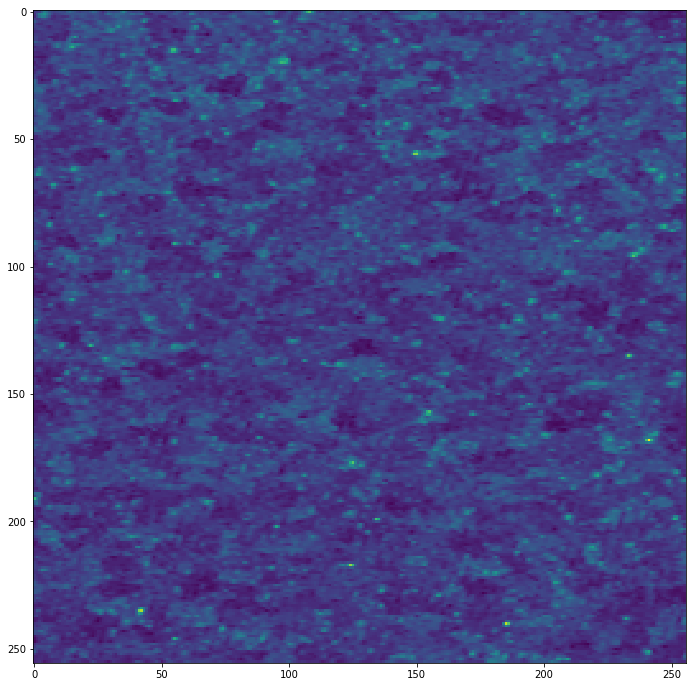

In [206]:
plt.imshow(clutterimgs[3455][0])

In [ ]:
import os

mask = np.zeros(clutterimgs[0][0].shape)
for img in clutterimgs: 
#     name = hashlib.sha256(str(img[0]).encode('utf-8')).hexdigest()
    name = "%d-%d" % (img[1], img[2])
    classname = "clutter"
    
    os.makedirs("%s/%s" % (folder, classname),exist_ok=True)
    plt.imsave("%s/%s/%s.png" % (folder, classname,name), img[0])
    plt.imsave("%s/%s/%s_mask.png" % (folder, classname,name), mask)
    
    

### Preparing RLE masks

In [194]:
rle = rle_encode(imgs_mask[imid])

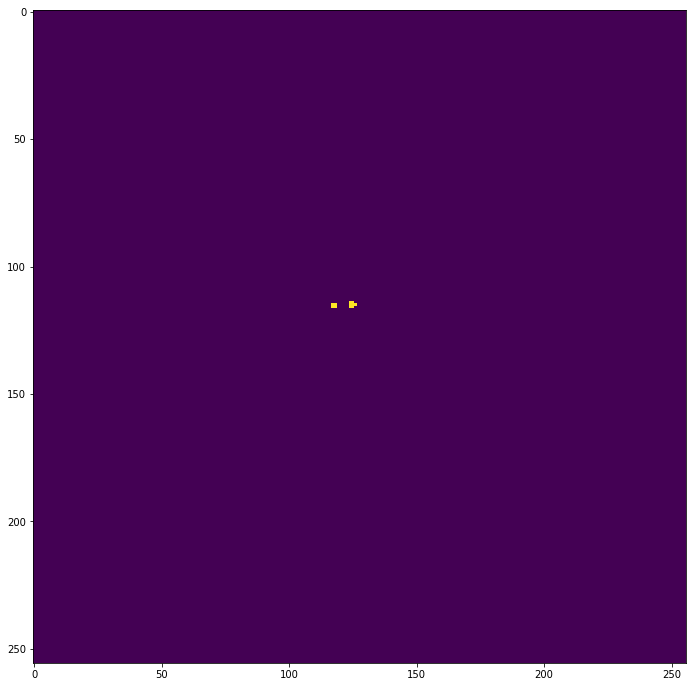

In [195]:
plt.imshow(np.array(np.round(imgs_mask[imid]),dtype=int))


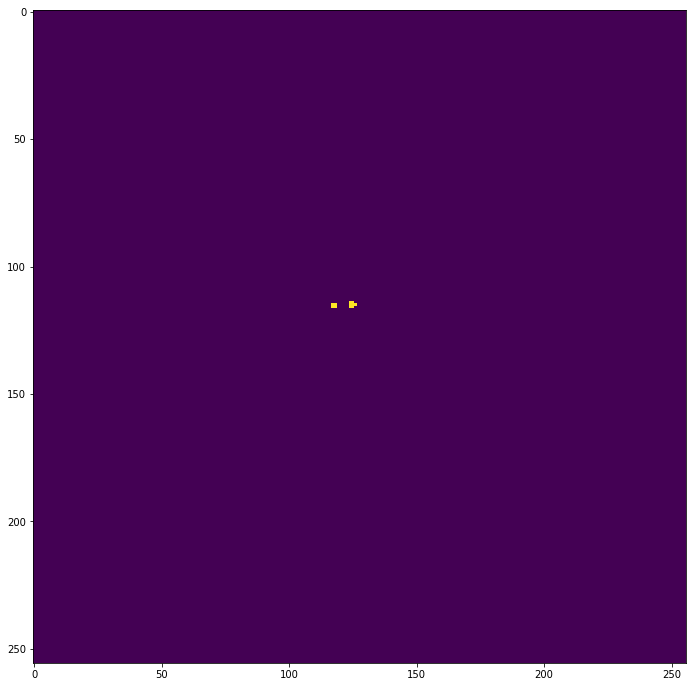

In [196]:
plt.imshow(rle_decode(rle, imgs[imid][0].shape))